In [1]:
"""
SDSS spectra Decompositions
---------------------------
Figure 7.4

A comparison of the decomposition of SDSS spectra using PCA (left panel -
see Section 7.3.1), ICA (middle panel - see Section 7.6) and NMF (right panel
- see Section 7.4). The rank of the component increases from top to bottom. For
the ICA and PCA the first component is the mean spectrum (NMF does not require
mean subtraction). All of these techniques isolate a common set of spectral
features (identifying features associated with the continuum and line
emission). The ordering of the spectral components is technique dependent.
"""
# Author: Jake VanderPlas
# License: BSD
#   The figure produced by this code is published in the textbook
#   "Statistics, Data Mining, and Machine Learning in Astronomy" (2013)
#   For more information, see http://astroML.github.com
#   To report a bug or issue, use the following forum:
#    https://groups.google.com/forum/#!forum/astroml-general


'\nSDSS spectra Decompositions\n---------------------------\nFigure 7.4\n\nA comparison of the decomposition of SDSS spectra using PCA (left panel -\nsee Section 7.3.1), ICA (middle panel - see Section 7.6) and NMF (right panel\n- see Section 7.4). The rank of the component increases from top to bottom. For\nthe ICA and PCA the first component is the mean spectrum (NMF does not require\nmean subtraction). All of these techniques isolate a common set of spectral\nfeatures (identifying features associated with the continuum and line\nemission). The ordering of the spectral components is technique dependent.\n'

In [2]:
import numpy as np
from matplotlib import pyplot as plt

from sklearn.decomposition import NMF, FastICA, PCA

from astroML.datasets import sdss_corrected_spectra
from astroML.utils.decorators import pickle_results

In [3]:
#----------------------------------------------------------------------
# This function adjusts matplotlib settings for a uniform feel in the textbook.
# Note that with usetex=True, fonts are rendered with LaTeX.  This may
# result in an error if LaTeX is not installed on your system.  In that case,
# you can set usetex to False.
if "setup_text_plots" not in globals():
    from astroML.plotting import setup_text_plots
setup_text_plots(fontsize=8, usetex=True)


/Users/dagoret/anaconda3/lib/python3.9/site-packages/astroML/linear_model/linear_regression_errors.py:10: UserWarning: LinearRegressionwithErrors requires PyMC3 to be installed
  warnings.warn('LinearRegressionwithErrors requires PyMC3 to be installed')


In [4]:
#----------------------------------------------------------------------
# Compute PCA, ICA, and NMF components
#  we'll save the results so that they can be re-used
@pickle_results('spec_decompositions.pkl')
def compute_PCA_ICA_NMF(n_components=5):
    spec_mean = spectra.mean(0)

    # PCA: use randomized PCA for speed
    pca = PCA(n_components - 1, random_state=0, svd_solver='randomized')
    pca.fit(spectra)
    pca_comp = np.vstack([spec_mean,
                          pca.components_])

    # ICA treats sequential observations as related.  Because of this, we need
    # to fit with the transpose of the spectra
    ica = FastICA(n_components - 1, random_state=0)
    ica.fit(spectra.T)
    ica_comp = np.vstack([spec_mean,
                          ica.transform(spectra.T).T])

    # NMF requires all elements of the input to be greater than zero
    spectra[spectra < 0] = 0
    nmf = NMF(n_components, random_state=0)
    nmf.fit(spectra)
    nmf_comp = nmf.components_

    return pca_comp, ica_comp, nmf_comp


## Download


In [5]:
#------------------------------------------------------------
# Download data
data = sdss_corrected_spectra.fetch_sdss_corrected_spectra()
spectra = sdss_corrected_spectra.reconstruct_spectra(data)
wavelengths = sdss_corrected_spectra.compute_wavelengths(data)

In [6]:
spectra.shape

(4000, 1000)

In [7]:
wavelengths.shape

(1000,)

(0.0, 50.0)

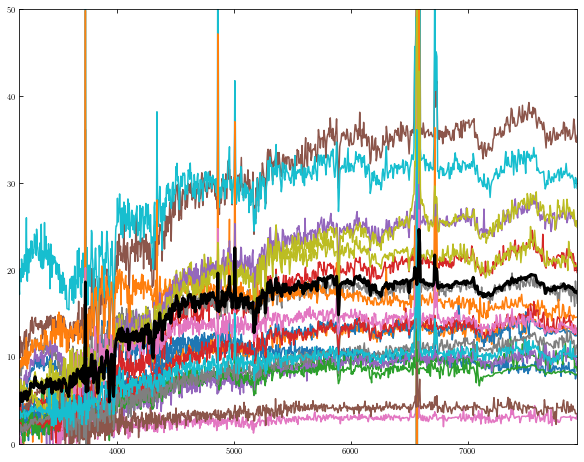

In [8]:
fig = plt.figure(figsize=(10, 8))

for idx in np.arange(20):
    
    plt.plot(wavelengths,spectra[idx,:])
  
spec_mean = spectra.mean(0)
plt.plot(wavelengths,spec_mean,"k-",lw=3)
plt.ylim(0,50.)

## Compute

In [9]:
n_components = 5
decompositions = compute_PCA_ICA_NMF(n_components)

@pickle_results: using precomputed results from 'spec_decompositions.pkl'


## Plot

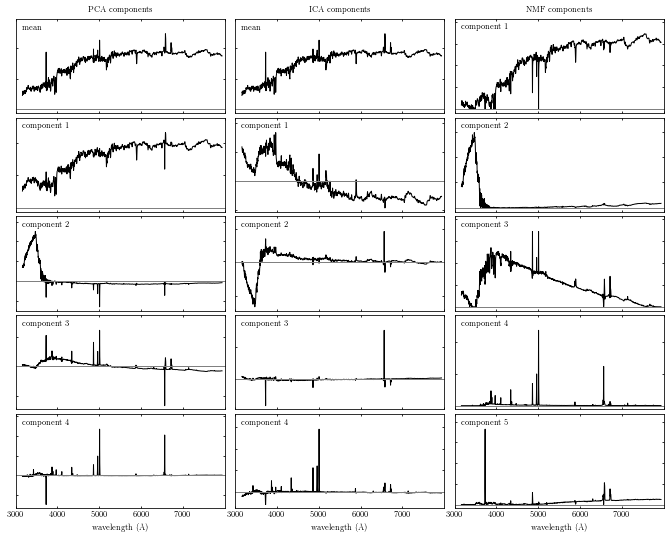

In [10]:
#----------------------------------------------------------------------
# Plot the results
fig = plt.figure(figsize=(10, 8))
fig.subplots_adjust(left=0.05, right=0.95, wspace=0.05,
                    bottom=0.1, top=0.95, hspace=0.05)

titles = ['PCA components', 'ICA components', 'NMF components']

for i, comp in enumerate(decompositions):
    for j in range(n_components):
        ax = fig.add_subplot(n_components, 3, 3 * j + 1 + i)

        ax.yaxis.set_major_formatter(plt.NullFormatter())
        ax.xaxis.set_major_locator(plt.MultipleLocator(1000))
        if j < n_components - 1:
            ax.xaxis.set_major_formatter(plt.NullFormatter())
        else:
            ax.xaxis.set_major_locator(
                plt.FixedLocator(list(range(3000, 7999, 1000))))
            ax.set_xlabel(r'wavelength ${\rm (\AA)}$')

        ax.plot(wavelengths, comp[j], '-k', lw=1)

        # plot zero line
        xlim = [3000, 8000]
        ax.plot(xlim, [0, 0], '-', c='gray', lw=1)

        if j == 0:
            ax.set_title(titles[i])

        if titles[i].startswith('PCA') or titles[i].startswith('ICA'):
            if j == 0:
                label = 'mean'
            else:
                label = 'component %i' % j
        else:
            label = 'component %i' % (j + 1)

        ax.text(0.03, 0.94, label, transform=ax.transAxes,
                ha='left', va='top')

        for l in ax.get_xticklines() + ax.get_yticklines():
            l.set_markersize(2)

        # adjust y limits
        ylim = plt.ylim()
        dy = 0.05 * (ylim[1] - ylim[0])

        ax.set_ylim(ylim[0] - dy, ylim[1] + 4 * dy)
        ax.set_xlim(xlim)


plt.show()
